In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
matplotlib.rcParams.update({ "pgf.texsystem": "pdflatex", 'font.family': 'serif', 'pgf.rcfonts': False,
                            "savefig.transparent" : True,  "svg.fonttype": 'none',  })
import matplotlib.pyplot as plt
usetex=False
plt.rc('font', family='Times New Roman')
plt.rc('text', usetex=usetex)
plt.rc("svg", fonttype='none')
if usetex:
       plt.rc('text.latex', preamble=
              r'\usepackage{amsmath}'\
              + "\n" + r'\usepackage{amssymb}'
              )
import matplotlib.figure, matplotlib.axes
import sys
import numpy as np
import pickle as pkl
import tqdm
import collections.abc
import torch
from utils import PredictionResults, color
import os
import matplotlib.transforms
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
import matplotlib.figure
from matplotlib.gridspec import GridSpec
from scipy.spatial.transform import Rotation
from scipy.interpolate import BSpline, make_interp_spline
import yaml 
import torch.utils.data as torchdata

print(os.getenv("PYTHONPATH"))
print(sys.path)

from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils

/home/deepracing/trent/deepracingws/src/deepracing/DCNN-Pytorch:/home/deepracing/trent/deepracingws/src/deepracing/deepracing_py:/home/deepracing/trent/deepracingws/src/deepracing_ros/deepracing_rclpy:
['/home/deepracing/trent/deepracingws/src/deepracing/DCNN-Pytorch', '/home/deepracing/trent/deepracingws/src/deepracing/deepracing_py', '/home/deepracing/trent/deepracingws/src/deepracing_ros/deepracing_rclpy', '/home/deepracing/trent/deepracingws/src/deepracing/DCNN-Pytorch/plotting', '/home/deepracing/trent/python310/lib/python310.zip', '/home/deepracing/trent/python310/lib/python3.10', '/home/deepracing/trent/python310/lib/python3.10/lib-dynload', '', '/home/deepracing/trent/venvs/deepracing310/lib/python3.10/site-packages']


In [3]:
keys : set = {
    "hist",
    "hist_tangents",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_tangents",
    "fut_quats",
    "future_arclength",
    "future_arclength_2d",
    "fut_vel",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "future_centerline",
    "future_raceline",
    "future_left_bd_tangents",
    "future_right_bd_tangents",
    "future_centerline_tangents",
    "future_raceline_tangents",
    "thistory",
    "tfuture",
    "future_left_bd_arclength",
    "future_right_bd_arclength",
    "future_centerline_arclength",
    "future_raceline_arclength",
    "current_position",
    "current_orientation" 
}
with open("config.yaml", "r") as f:
    configdict : dict = yaml.safe_load(f)
realdata : bool = configdict["realdata"]
data_dir = "/p/DeepRacing/unpacked_datasets/iac_data_v3/deepracing_standard" if realdata \
           else "/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard"
mtr_data_dir = os.path.join(os.path.dirname(data_dir), "mtr_format", "1second")
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files(data_dir,
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)

fut_tangents_all = np.stack([fulldset[i]["fut_tangents"] for i in range(len(fulldset))], axis=0)[:,:,[0,1]]
fut_tangents_all = fut_tangents_all/np.linalg.norm(fut_tangents_all, ord=2.0, axis=-1, keepdims=True)
# q_all = np.stack([fulldset[i]["fut_quats"] for i in range(len(fulldset))], axis=0)
# R_all = Rotation.from_quat(q_all.reshape(-1, 4))
# M_all = R_all.as_matrix().reshape(fut_tangents_all.shape[0], fut_tangents_all.shape[1], 3, 3)
# upvecs = M_all[:,:,-1]
# fut_normals_all = np.cross(upvecs, fut_tangents_all, axis=-1)
fut_normals_all = fut_tangents_all[:,:,[1,0]].copy()
fut_normals_all[:,:,0]*=-1.0


if realdata:
    bezier_experiment = "registered_ottoman_7483"
    bezier_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/bezier_mixnet", bezier_experiment)
    composite_experiment = "musical_raccoon_7407" #encouraging_corolla_2210 musical_raccoon_7407
    composite_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/barte", composite_experiment)
    mixnet_experiment = "symbolic_varnish_9248"
    mixnet_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mixnet", mixnet_experiment)
    mtr_experiment = "worldwide_perch_1278"
    mtr_results_dir =  os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mtr", mtr_experiment)
else:
    bezier_experiment = "widespread_beans_6059"
    bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
    composite_experiment = "chosen_preservative_7505"
    composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
    mixnet_experiment = "agricultural_flue_8932"
    mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
    mtr_experiment = "formal_pedestal_9890"
    mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results/sim_data", mtr_experiment, "test_plots")


bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BézierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "BARTé")
composite_results.compute_fde()
composite_curves = torch.as_tensor(composite_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
# if not realdata:
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
composite_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()


mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "data.npz"), "MTR")
mtr_results["predictions_old"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(composite_results["predictions"])
for idx in range(mtr_results["predictions_old"].shape[0]):
    mtr_fitpoints = mtr_results["predictions_old"][idx,mtr_results["best_curve_idx"][idx]]
    tfuture_curr = tfuture_np[idx].copy()
    mtr_pred_spline : BSpline = make_interp_spline(np.linspace(tfuture_curr[0], tfuture_curr[-1], num=mtr_fitpoints.shape[0]+1), 
                                                   np.concatenate([np.zeros_like(mtr_fitpoints[0])[None], mtr_fitpoints], axis=0), k=1)
    mtr_results["predictions"][idx] = mtr_pred_spline(tfuture_curr)
mtr_results["ground_truth"] = np.stack([fulldset[i]["fut"] for i in range(len(fulldset))], axis=0)
mtr_results.compute_fde()


all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, composite_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))


all_results_composite_ref = [composite_results, mtr_results, bezier_results, mixnet_results]
all_results_mtr_ref = [mtr_results, composite_results, bezier_results, mixnet_results]
base_path="/p/DeepRacing/trajectory_prediction_results"

Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_0/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_1/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_2/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_3/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_4/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_5/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepr

In [4]:
composite_results.compute_full_latlong(fut_tangents_all, fut_normals_all)
mtr_results.compute_full_latlong(fut_tangents_all, fut_normals_all)
bezier_results.compute_full_latlong(fut_tangents_all, fut_normals_all)
mixnet_results.compute_full_latlong(fut_tangents_all, fut_normals_all)

In [5]:

%autoreload 2
import matplotlib.collections
import utils
import matplotlib.axes
import matplotlib.legend
import matplotlib.animation
import matplotlib.patches
import matplotlib.gridspec
from matplotlib.legend_handler import HandlerPatch
all_results = [composite_results, mtr_results, bezier_results, mixnet_results]


In [ ]:
#Error Animation
%matplotlib widget
%autoreload 2
from ftplib import all_errors
import matplotlib.axes
import matplotlib.gridspec
import random
import matplotlib.lines
plt.rc("font", family="Times New Roman")
mtr_longerror_sort = np.flipud(np.argsort(mtr_results["longitudinal_error"]))
longerrorthresh = 1.75
metric = "longitudinal_error"
mtr_bad = mtr_results[metric]>longerrorthresh
mixnet_bad = mixnet_results[metric]>longerrorthresh
bezier_bad = bezier_results[metric]>longerrorthresh
barte_good = composite_results[metric]<(0.35*longerrorthresh)
idx_all = np.arange(0, len(fulldset), step=1, dtype=np.int64)[mtr_bad*mixnet_bad*bezier_bad*barte_good]
print(idx_all.shape[0])
carwidth = 1.930
carlength = 4.877
# idx_rand = 23411
# idx_rand = 49891
# idx_rand = 49302
# idx_rand = 95635
# idx_rand = 35839
# idx_rand = 91470
# idx_rand = 81196
# idx_rand = 64389
# idx_rand = 31507
# idx_rand = 91470
# idx_rand = 35449
# idx_rand = 53598
# idx_rand = 44983
# idx_rand = 122031
idx_rand = 44983
# idx_rand = int(random.sample(idx_all.tolist(), 1)[0])
print(idx_rand)
sample = fulldset[idx_rand]
devicedtype = {"dtype" : torch.float64, "device" : torch.device("cpu")}
thistory = torch.as_tensor(sample["thistory"].copy(), **devicedtype)
history = torch.as_tensor(sample["hist"].copy(), **devicedtype)
tfuture = torch.as_tensor(sample["tfuture"].copy(), **devicedtype)
ground_truth = torch.as_tensor(sample["fut"].copy(), **devicedtype)
ground_truth_tangents = torch.as_tensor(sample["fut_tangents"].copy(), **devicedtype)
ground_truth_normals = ground_truth_tangents[:,[1,0]].clone()
ground_truth_normals[:,0]*=-1.0
ground_truth_normals/=torch.norm(ground_truth_normals, p=2.0, dim=1, keepdim=True)
future_left_bd = torch.as_tensor(sample["future_left_bd"].copy(), **devicedtype)
future_right_bd = torch.as_tensor(sample["future_right_bd"].copy(), **devicedtype)
t0 = tfuture[0].item()
thistory = thistory - t0
tfuture = tfuture - t0
try:
    plt.close(fig=fig) # type: ignore
except:
    pass    
gridsize = (3,2) #, layout = "tight"
figsize = 14.0*np.asarray([1.0, 9.0/16.0])
fig = plt.figure(figsize=figsize, layout="constrained")
gs : matplotlib.gridspec.GridSpec = matplotlib.gridspec.GridSpec(*gridsize, figure=fig)
ax : list[matplotlib.axes.Axes] = [
    fig.add_subplot(gs[:,:-1]),
    fig.add_subplot(gs[0,-1]),
    fig.add_subplot(gs[1,-1]),
    fig.add_subplot(gs[2,-1]),
]
# ax[1].sharex(ax[-1])
# ax[2].sharex(ax[-1])
key_to_name = {"longitudinal_error_full" : "Longitudinal Error", "lateral_error_full" : "Lateral Error", "ade_full" : "ADE"}
error_artists : dict[str,list[matplotlib.lines.Line2D]] = {r.modelname : [] for r in all_results} 
line_artists : dict[str,matplotlib.lines.Line2D]  = dict()
animations_dir = os.path.join(base_path, "animations")
error_animation_dir = os.path.join(animations_dir, "error_animation")
import shutil
if os.path.isdir(error_animation_dir):
    shutil.rmtree(error_animation_dir)
os.makedirs(error_animation_dir)

def static_elements(save_file : bool):
    global fig, ax, fixed_artists, text_artist, tfuture, gtartist, key_to_name, error_artists, line_artists, line_title_text, error_title_text
    ax_position : matplotlib.axes.Axes = ax[0]  
    ax_position.clear()
    error_artists.clear()
    error_artists = {r.modelname : [] for r in all_results} 
    line_artists.clear()
    line_title_text = ax_position.set_title("Predicted Curves & Ground Truth", fontsize=16)
    ax_position.set_xlabel("X Position (meters)", fontsize=line_title_text.get_fontsize())
    ax_position.set_ylabel("Y Position (meters)", fontsize=line_title_text.get_fontsize())
    lbartist, = ax_position.plot(future_left_bd[:,0], future_left_bd[:,1], label="Track Boundaries", color="black")
    rbartist, = ax_position.plot(future_right_bd[:,0], future_right_bd[:,1], color=lbartist.get_color(), alpha=lbartist.get_alpha(), linestyle=lbartist.get_linestyle())
    all_points_list = []
    for results in all_results:
        line_artists[results.modelname] = ax_position.plot([], [], label=results.modelname)[0]
        current_preds = results["predictions"][idx_rand]
        all_points_list.append(current_preds[:,[0,1]])
    gtartist  = ax_position.scatter([], [], color="green", label="Ground Truth", s=2**3)

    text_artist  = ax_position.plot([], [])[0]

    all_points_list.extend([future_left_bd[:,[0,1]].cpu().numpy(), future_right_bd[:,[0,1]].cpu().numpy()])
    all_points = np.concatenate(all_points_list, axis=0)
    minx, maxx = float(all_points[:,0].min()) - 1.0, float(all_points[:,0].max()) + 1.0
    miny, maxy = float(all_points[:,1].min()) - 1.0, float(all_points[:,1].max()) + 1.0
    ax_position.set_xlim(minx, maxx)
    ax_position.set_ylim(miny, maxy)
    aspect_ratio = (maxx - minx)/(maxy - miny)
    aspect_factor = 0.75
    ax_position.set_aspect(aspect_factor*aspect_ratio + 1.0 - aspect_factor, adjustable="datalim")
    error_axes : list[matplotlib.axes.Axes] = [ax[i] for i in range(1,len(ax))]  
    fixed_artists = [lbartist, rbartist, gtartist, ax_position.legend(frameon=False), line_title_text]
    for (i, error_key) in enumerate(sorted(list(key_to_name.keys()), reverse=True)):
        ax_error : matplotlib.axes.Axes = error_axes[i]
        ax_error.clear()
        ax_error.set_xlim(tfuture[0].item() - 0.1, tfuture[-1].item() + 0.1) 
        ax_error.set_ylabel("%s (meters)" % (key_to_name[error_key],), fontsize=line_title_text.get_fontsize()-4)
        all_error = np.concatenate([d[error_key][idx_rand] for d in all_results], axis=0)
        for results in all_results:
            error_artists[results.modelname].extend(ax_error.plot([], [], label=results.modelname, color=line_artists[results.modelname].get_color()))
        if error_key=="longitudinal_error_full":
            fixed_artists.append(ax_error.axhline(y=0.5*carlength, linestyle="--", color="grey", label="1/2 Car Length"))
            all_error = np.concatenate([all_error, np.asarray([carlength,])], axis=0)
            current_legend = ax_error.legend(loc="upper left", bbox_to_anchor=[0.0, 1.0], frameon=False)
        elif error_key=="lateral_error_full":
            fixed_artists.append(ax_error.axhline(y=0.5*carwidth, linestyle="--", color="grey", label="1/2 Car Width"))
            all_error = np.concatenate([all_error, np.asarray([carwidth,])], axis=0)
            current_legend = ax_error.legend(loc="upper left", bbox_to_anchor=[0.0, 1.0], frameon=False)
        else:
            current_legend = ax_error.legend(loc="upper left", bbox_to_anchor=[0.0, 1.0], frameon=False)
        ax_error.set_ylim(-0.05, np.max(all_error) + 0.25)
        if not (i==(len(error_axes)-1)):
            ax_error.xaxis.set_ticklabels([])
        # ax_error.yaxis.tick_right()
        # ax_error.yaxis.set_label_position("right")
        fixed_artists.append(current_legend)
    fixed_artists.append(error_axes[-1].set_xlabel("Time (seconds)", fontsize=line_title_text.get_fontsize()))
    fixed_artists.append(error_axes[0].set_title("Error Metrics vs Time", fontsize=line_title_text.get_fontsize()))
    if save_file:
        filebase = os.path.join(error_animation_dir, "initial_frame")
        fig.savefig("%s.png" % (filebase,), bbox_inches="tight", transparent=True, backend="agg")
        fig.savefig("%s.svg" % (filebase,), bbox_inches="tight", transparent=True)
    return fixed_artists
def dynamic_elements(save_file : bool, idx : int):
    global  fig, ax, fixed_artists, text_artist, tfuture, gtartist, line_artists, error_artists, key_to_name, line_title_text
    for modelname, lineartist in line_artists.items():
        lineartist.remove()
        for errorartist in error_artists[modelname]:
            errorartist.remove()
    error_artists.clear()
    error_artists = {r.modelname : [] for r in all_results} 
    ax_position : matplotlib.axes.Axes = ax[0]  #]:#
    gtartist = ax_position.scatter(ground_truth[:idx,0], ground_truth[:idx,1], s=gtartist.get_sizes()[0], color=gtartist.get_facecolor())

    t = tfuture[idx].item()
    text_artist.remove()
    text_artist = ax_position.text(0.5, 0.5, "t=%1.2f seconds" % (t,), fontsize=line_title_text.get_fontsize(), transform=ax_position.transAxes)
    new_artists = [text_artist,]
    for results in all_results:
        toplot = results["predictions"][idx_rand,:idx]
        line_artists[results.modelname] = ax_position.plot(toplot[:,0], toplot[:,1], color=line_artists[results.modelname].get_color())[0]
        new_artists.append(line_artists[results.modelname])
    for (i, error_key) in enumerate(sorted(list(key_to_name.keys()), reverse=True)):
        ax_error : matplotlib.axes.Axes = ax[i+1]
        for results in all_results:
            error_artists[results.modelname].extend(ax_error.plot(tfuture[:idx], results[error_key][idx_rand,:idx], color=line_artists[results.modelname].get_color()))
            new_artists.append(error_artists[results.modelname][-1])
    if save_file:
        filebase = os.path.join(error_animation_dir, "frame_%d" % (idx,))
        fig.savefig("%s.png" % (filebase,), bbox_inches="tight", transparent=True, backend="agg")
        fig.savefig("%s.svg" % (filebase,), bbox_inches="tight", transparent=True)
    return fixed_artists + new_artists
import functools
steps = composite_results["predictions"].shape[1] 

animation_length=tfuture[-1].item() #sec
slowdown_factor = 0.25
interval = int(round(1000.0*animation_length/(steps*slowdown_factor))) #ms/frame
fps = int(round(1000/interval))

frames = np.linspace(0, steps-1, num=steps, dtype=np.int64)
animation_steps = int(round(1000.0*animation_length/interval))
import matplotlib.animation
save_initial = True
save_dynamic = False
animation = matplotlib.animation.FuncAnimation(fig, functools.partial(dynamic_elements, save_dynamic), frames=frames.tolist(), init_func=functools.partial(static_elements, save_initial), interval=interval, blit=True, repeat=False, cache_frame_data=True)

error_animation_file = os.path.join(animations_dir, "%s.mp4" % (os.path.basename(error_animation_dir),))
animation.save(error_animation_file)

113154


/tmp/ipykernel_527285/633201048.py:143: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax_pos.legend(handles=straight_line_artists + [gt_artist,])
/tmp/ipykernel_527285/633201048.py:143: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax_pos.legend(handles=straight_line_artists + [gt_artist,])


yay


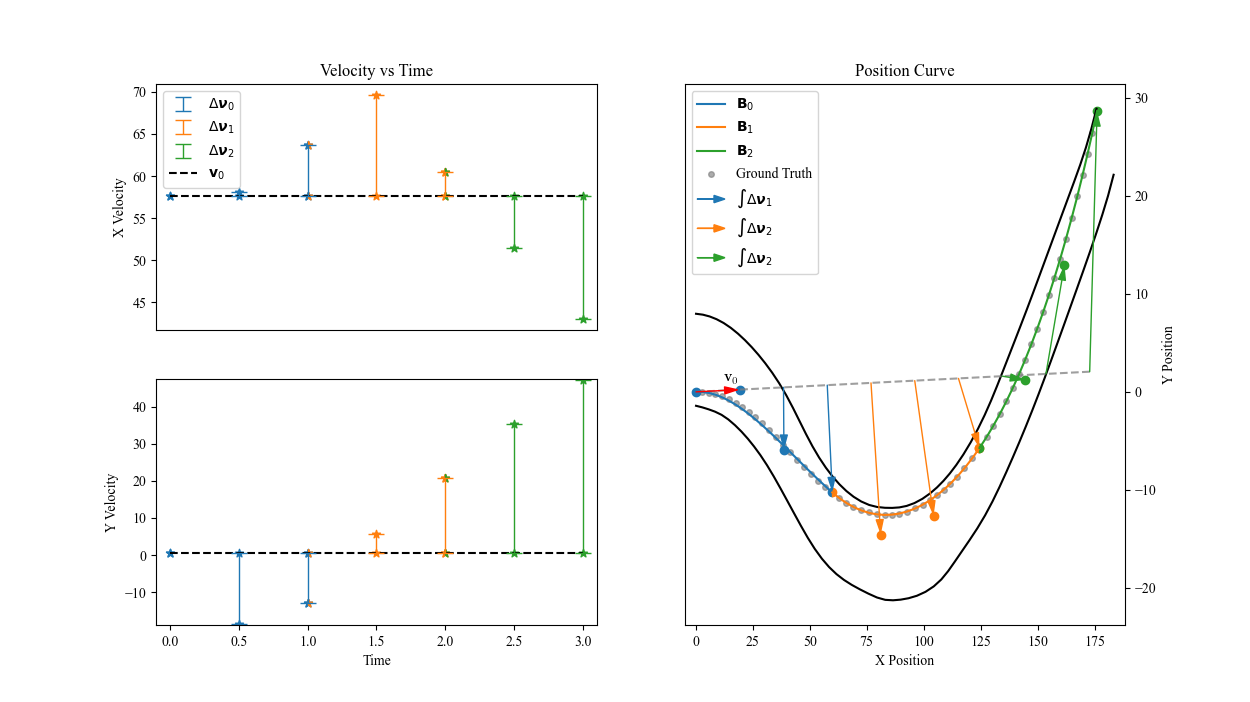

In [18]:
#Offset Animation
%matplotlib widget
%autoreload 2
import matplotlib.patches
import matplotlib.text
import matplotlib.axes
import matplotlib.transforms
import matplotlib.scale
plt.rc("font", family="Times New Roman")
# idx_rand = int(np.random.randint(0, high=len(fulldset), size=1)[0])
# idx_rand = 101355
idx_rand = 113154
# idx_rand = 13330
# idx_rand = 44498
# idx_rand = 114110

print(idx_rand)
sample = fulldset[idx_rand]
devicedtype = {"dtype" : torch.float64, "device" : torch.device("cuda:0")}
pmask = np.ones(3)
qmask = np.ones(4)
current_position = sample["current_position"]*pmask
current_orientation = Rotation.from_quat(sample["current_orientation"]*qmask)
history, history_global = torch.as_tensor(sample["hist"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["hist"]) + current_position, **devicedtype)
ground_truth, ground_truth_global = torch.as_tensor(sample["fut"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["fut"]) + current_position, **devicedtype)
future_left_bd, future_left_bd_global = torch.as_tensor(sample["future_left_bd"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["future_left_bd"]) + current_position, **devicedtype)
future_right_bd, future_right_bd_global = torch.as_tensor(sample["future_right_bd"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["future_right_bd"]) + current_position, **devicedtype)


history_vel, history_vel_global = torch.as_tensor(sample["hist_vel"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["hist_vel"]), **devicedtype)
future_vel, future_vel_global = torch.as_tensor(sample["fut_vel"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["fut_vel"]), **devicedtype)
thistory = torch.as_tensor(sample["thistory"].copy(), **devicedtype)
tfuture = torch.as_tensor(sample["tfuture"].copy(), **devicedtype)
t0 = tfuture[0].item()
thistory = thistory - t0
tfuture = tfuture - t0
Nseg = 3
kbezier = 3
tswitch : torch.Tensor = torch.linspace(tfuture[0], tfuture[-1], steps=Nseg+1, **devicedtype)
tstart = tswitch[:-1]
dT = tswitch[1:] - tswitch[:-1]
nu0 = torch.ones([Nseg, kbezier, future_vel.shape[-1]], **devicedtype)*future_vel[None,None,0]
cbc_straightline = mu.compositeBezierAntiderivative(nu0, dT)
cbc_gt_full, _ = mu.compositeBezierFit(tfuture, ground_truth, Nseg, constraint_level=2, kbezier=kbezier, dYdT_0=future_vel[0], dYdT_f=future_vel[-1])
cbc_delta = cbc_gt_full - cbc_straightline

# cbc_gt = cbc_gt[0]
try:
    plt.close(fig=fig) # type: ignore
except:
    pass
fig_width = 12.5
aspect_ratio = 16.0/9.0
fig_height = fig_width/aspect_ratio
fig = plt.figure(figsize=(fig_width, fig_height)) 
grid_spec = matplotlib.gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
position_column = 1
velocity_column = (position_column+1)%2
ax_pos : matplotlib.axes.Axes = fig.add_subplot(grid_spec[:,position_column])
# fig.add
# ax_vel : list[matplotlib.axes.Axes] = grid_spec.subplots(1,2, sharex=True)
ax_velx : matplotlib.axes.Axes = fig.add_subplot(grid_spec[0,velocity_column])
ax_vely : matplotlib.axes.Axes = fig.add_subplot(grid_spec[1,velocity_column])
plt.setp(ax_velx.get_xticklabels(), visible=False)


new_artists = []
vel_artists = [[], []]
scatterargs = {"tplot" : tfuture.cpu(), "tswitch" : tswitch.cpu(), "visible" : True}
position_legend = False
animations_dir = os.path.join(base_path, "animations")
def draw_static_elements(ax_pos : matplotlib.axes.Axes, ax_vel : list[matplotlib.axes.Axes], with_legend : bool):
    global colors, base_artists, gt_artist, straight_line_artists, scatterargs, cbc_gt_full, cbc_straightline, tfuture, tswitch, nu0, Nseg, kbezier, position_legend
    try:
        ax_pos.clear()
    except:
        pass
    all_points = torch.cat([
        cbc_gt_full.view(Nseg*(kbezier+1), -1),
        ground_truth,
        future_left_bd,
        future_right_bd
    ], dim=0) 
    delta = torch.as_tensor([5.0, 2.5, 0.0], dtype=all_points.dtype, device=all_points.device)
    mins, idxmins = torch.min(all_points, 0, keepdim=False) 
    mins-=delta
    maxes, idxmaxes = torch.max(all_points, 0, keepdim=False)
    maxes+=delta
    ax_pos.set_xlim(mins[0].item(), maxes[0].item())
    ax_pos.set_ylim(mins[1].item(), maxes[1].item())
    dT = tswitch[1:]-tswitch[:-1]
    cbc_vel_full = kbezier*(cbc_gt_full[:,1:] - cbc_gt_full[:,:-1])/dT[:,None,None]
    all_vels = torch.cat([
        cbc_vel_full.view(Nseg*kbezier, -1),
        future_vel
    ], dim=0) 
    vel_delta = torch.as_tensor([1.25, 0.25, 0.0], dtype=all_vels.dtype, device=all_vels.device)
    mins_vel, _ = torch.min(all_vels, 0, keepdim=False) 
    mins_vel-=vel_delta
    maxes_vel, _ = torch.max(all_vels, 0, keepdim=False)
    maxes_vel+=vel_delta
    tlims = tfuture[[0,-1]] + 0.1*torch.as_tensor([-1.0, 1.0], dtype=tfuture.dtype, device=tfuture.device)
    ax_vel[0].set_xlim(*tlims.cpu())
    ax_vel[1].set_xlim(*tlims.cpu())
    ax_vel[0].set_ylim(mins_vel[0].item(), maxes_vel[0].item())
    ax_vel[1].set_ylim(mins_vel[1].item(), maxes_vel[1].item())
    colors, _, straight_line_artists = utils.scatter_composite_xy(cbc_straightline[:,:,[0,1]].cpu(), ax_pos, with_labels=with_legend, **scatterargs)
    scatterargs["visible"] = False
    _, vel_artists = utils.scatter_composite_axes(nu0[...,:-1].cpu(), tswitch.cpu(), ax_vel, colors=colors, marker="*")
    vel_artists[0].append(ax_vel[0].hlines(future_vel[0,0].item(), xmin=tswitch[0].item(), xmax=tswitch[-1].item(), color="black", linestyle="--", label="$\\mathbf{v}_{0}$"))
    vel_artists[1].append(ax_vel[1].hlines(future_vel[0,1].item(), xmin=tswitch[0].item(), xmax=tswitch[-1].item(), color="black", linestyle="--"))
    
    
    # data_to_axes :  matplotlib.transforms.Transform = ax_pos.transData + (ax_pos.transAxes.inverted())
    data_to_axes :  matplotlib.transforms.Transform = ax_pos.transLimits
    axes_to_data = data_to_axes.inverted()

    arrowstyle = matplotlib.patches.ArrowStyle.CurveFilledB(head_width=0.25, head_length=0.9, widthA=3.25, widthB=3.25)
    arrowprops : dict = dict(arrowstyle=arrowstyle, shrinkA=0.0, shrinkB=0.0, color="red")
    head_tf = matplotlib.transforms.ScaledTranslation(*cbc_straightline[0,1,[0,1]].cpu().numpy().tolist(), data_to_axes) + ax_pos.transAxes
    e0_annotation  = ax_pos.annotate("", [0.0, 0.0], xycoords=head_tf, xytext=cbc_straightline[0,0,[0,1]].cpu(), textcoords="data", arrowprops=arrowprops)
    e0_arrowpatch : matplotlib.patches.FancyArrowPatch = e0_annotation.arrow_patch
    affinemat = np.eye(3)
    affinemat[1,1] = 0.5
    tf : matplotlib.transforms.Transform = \
        matplotlib.transforms.blended_transform_factory(ax_pos.transData, 
                                                        matplotlib.transforms.ScaledTranslation(0.0, 0.0, data_to_axes) + ax_pos.transAxes)
    e0_text : matplotlib.text.Text = ax_pos.text(.80*cbc_straightline[0,1,0].item(), 0.025, "$\mathbf{v}_0$", usetex=True, transform=tf,
                                                 horizontalalignment="center", verticalalignment="center")
    
    ax_pos.set_title("Position Curve")
    ax_pos.set_xlabel("X Position")
    ax_pos.set_ylabel("Y Position")
    ax_pos.yaxis.tick_right()
    ax_pos.yaxis.set_label_position("right")
    ax_vel[0].set_title("Velocity vs Time")
    ax_vel[0].set_ylabel("X Velocity")
    ax_vel[1].set_xlabel("Time")
    ax_vel[1].set_ylabel("Y Velocity")
    ax_vel[0].xaxis.set_ticks([])
    gt_artist=ax_pos.scatter(ground_truth[:,0].cpu(), ground_truth[:,1].cpu(), s=16.0, color="grey", alpha=0.65, label="Ground Truth") 
    if with_legend:
        ax_pos.legend(handles=straight_line_artists + [gt_artist,])
        ax_vel[0].legend(loc="upper left")
    base_artists = [gt_artist, e0_annotation]
    base_artists.extend(ax_pos.plot(future_left_bd[:,0].cpu(), future_left_bd[:,1].cpu(), color="black", label="Track Boundaries"))
    base_artists.extend(ax_pos.plot(future_right_bd[:,0].cpu(), future_right_bd[:,1].cpu(), color="black"))
    base_artists.append(vel_artists[0][-1])# + vel_artists[1] + vel_artists[0]
    return base_artists
legend = None
def partial_offset(ax_pos : matplotlib.axes.Axes, ax_vel : list[matplotlib.axes.Axes], ratio : float):
    global fig, colors, base_artists, gt_artist, straight_line_artists, new_artists, cbc_straightline, cbc_delta, scatterargs, kbezier, tswitch, Nseg, legend, vel_artists, position_legend
    if ratio==0.0:
        return base_artists
    elif len(straight_line_artists)>0:
        s = torch.linspace(0.0, 1.0, steps=60)
        p0 = cbc_straightline[0,0].cpu().clone()
        pF = cbc_straightline[-1,-1].cpu().clone()
        line = pF*s[:,None] + p0
        base_artists = ax_pos.plot(line[:,0], line[:,1], linestyle="--", color="grey", alpha=0.75) + base_artists
        for artist in straight_line_artists:
            artist.remove()
        straight_line_artists.clear()
    for artist in new_artists:
        if artist in base_artists:
            continue
        artist.remove()
    new_artists.clear()
    cbc_gt = cbc_straightline + ratio*cbc_delta
    _, _, new_artists = utils.scatter_composite_xy(cbc_gt[:,:,[0,1]].cpu(), ax_pos, colors = colors, **scatterargs)
    arrowstyle = matplotlib.patches.ArrowStyle.CurveFilledB(head_width=0.25, head_length=0.9, widthA=2.25, widthB=2.25)
    arrowprops : dict = dict(arrowstyle=arrowstyle, shrinkA=0.0, shrinkB=0.0)
    handler_map : dict = dict()
    for i in (range(Nseg) if ratio>0.0 else []):
        idxpoints = torch.arange(2, kbezier+1, step=1, dtype=torch.int64) if i==0 else torch.arange(1, kbezier+1, step=1, dtype=torch.int64)
        p0vec = cbc_straightline[i, idxpoints].cpu()
        pfvec = cbc_gt[i, idxpoints].cpu()
        arrowprops["color"] = colors[i]
        arrowprops.pop("label", None)
        for j in range(p0vec.shape[0]):
            p0 = p0vec[j,:2]
            pf = pfvec[j,:2] #visible=scatterargs["visible"], 
            with plt.rc_context({"text.usetex" : True}) as ctx:
                annotation = ax_pos.annotate("", pf, xytext=p0, arrowprops=arrowprops)
                if j==(p0vec.shape[0]-1):
                    fakearrow = ax_pos.arrow(0, 0, 0.0, 0.0, label="$\\int \\Delta \\boldsymbol{\\nu}_%d$" % (j,), color=arrowprops["color"])
                    handler_map[fakearrow] = HandlerPatch(patch_func = lambda legend, orig_handle, xdescent, ydescent, width, height, fontsize, annotation=annotation,arrowprops=arrowprops :  
                                                          matplotlib.patches.FancyArrow(0.0, 0.5*height, width, 0.0, length_includes_head=True, head_width=0.75*height, color=arrowprops["color"]))
                new_artists.append(annotation)
        # with plt.rc_context({"text.usetex" : True}) as ctx:fakescatte
    if not position_legend:
        legend_handles = [handle for handle in (new_artists + [gt_artist,]) if not ( (type(handle)==matplotlib.collections.LineCollection) or (type(handle)==matplotlib.legend.Legend) or (handle.get_label().startswith('_')) or (handle.get_label()==''))]
        legend_handles.extend(list(handler_map.keys()))
        legend=ax_pos.legend(handles=legend_handles, handler_map=handler_map)
        base_artists.insert(0,legend)
        position_legend=True
    for artist in (vel_artists[0]+ vel_artists[1]):
        if artist in base_artists:
            continue
        artist.remove()
    dT = tswitch[1:]-tswitch[:-1]
    cbc_vel = kbezier*(cbc_gt[:,1:] - cbc_gt[:,:-1])/dT[:,None,None]
    _, vel_artists = utils.scatter_composite_axes(cbc_vel[...,:-1].cpu(), tswitch.cpu(), ax_vel, colors=colors, marker="*", ref_vel=future_vel[0,:-1])
    legend_handles_vel = [handle for handle in vel_artists[0] if not (type(handle)==matplotlib.legend.Legend or handle.get_label().startswith('_') or handle.get_label()=='')] + [base_artists[-1],]
    # print(legend_handles_vel)
    legend_vel =  ax_vel[0].legend(handles=legend_handles_vel, loc="upper left")
    return base_artists + new_artists + vel_artists[0] + vel_artists[1] + [legend_vel,]
import functools
draw_static_elements(ax_pos, [ax_velx, ax_vely], True)
fig.savefig(os.path.join(animations_dir, "offset_animation.initial_frame.png"), backend="agg", transparent=False, bbox_inches="tight")
fig.savefig(os.path.join(animations_dir, "offset_animation.initial_frame.svg"), backend="svg", transparent=False, bbox_inches="tight")
ax_pos.clear()
ax_velx.clear()
ax_vely.clear()
offset_animation_file = os.path.join(animations_dir, "offset_animation.mp4")
os.makedirs(os.path.dirname(offset_animation_file), exist_ok=True)
init_func = functools.partial(draw_static_elements, ax_pos, [ax_velx, ax_vely], True)
boundfunc = functools.partial(partial_offset, ax_pos, [ax_velx, ax_vely])

static_length = .75 # sec
animation_length= 2.5 #sec
frame_rate = 30.0 #frames/sec
interval = int(round(1000.0/frame_rate)) #ms/frame
static_steps = int(round(1000.0*static_length/interval))
animation_steps = int(round(1000.0*animation_length/interval))

frames = torch.cat([ torch.zeros(static_steps), torch.linspace(0.0, 1.0, steps=animation_steps+1)[1:]])
animation = matplotlib.animation.FuncAnimation(fig, boundfunc, frames=frames.numpy().tolist(), init_func=init_func, interval=interval, blit=False, repeat=False, cache_frame_data=True)
# writer = matplotlib.animation.FFMpegWriter(fps=int(frame_rate))
# writer.frame_size = (fig_width, fig_height)
animation.save(offset_animation_file, savefig_kwargs={ "transparent" : True, "bbox_inches": "tight"})
print("yay")
# print(ax_pos.get_xlim())
# print(ax_pos.get_ylim()), savefig_kwargs={"transparent" : True}
# animation.to_jshtml()

102131
tensor([[8.7069e+01, 1.0673e+00],
        [8.7032e+01, 2.0261e+00],
        [8.7053e+01, 1.5575e+00],
        [8.7085e+01, 1.3251e-02],
        [8.7085e+01, 9.7226e-03]], dtype=torch.float64)
tensor([[36.3947,  7.9803],
        [36.3973,  8.1030],
        [36.3889,  7.7835],
        [34.3545, 17.0671],
        [34.4660, 16.8418]], dtype=torch.float64)
213.02051971007512
213.02051971007512
212.9702546331538


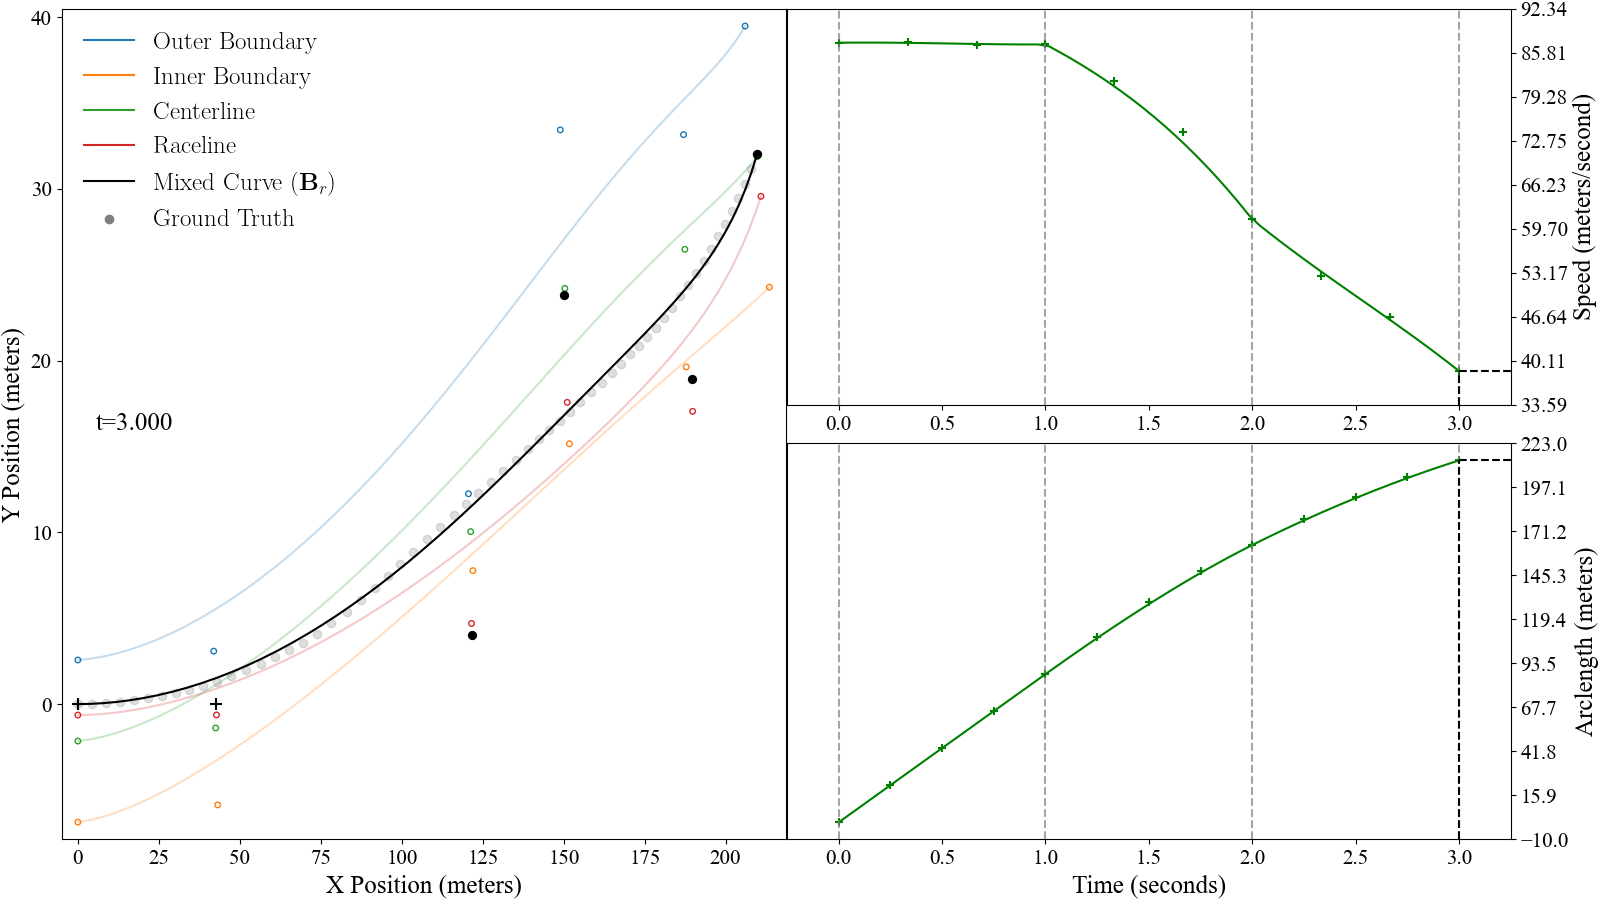

In [11]:
#Mixing Animation
%autoreload 2
%matplotlib widget
import utils
import shutil
import matplotlib.animation
import matplotlib.axes
import functools
# idx_samp = np.random.randint(0, high=len(fulldset))
# idx_samp = 122181
# idx_samp = 67785
# idx_samp = 30720
# idx_samp = 66581
# idx_samp = 35717
# idx_samp = 115347
# idx_samp = 35979
# idx_samp = 90611
# idx_samp = 17040
# idx_samp = 103054
idx_samp = 102131





print(idx_samp)

sample = fulldset[idx_samp]
devicedtype = {"device" : torch.device("cpu"), "dtype" : torch.float64}
gt = torch.as_tensor(sample["fut"][:,[0,1]], **devicedtype)
gt_vel = torch.as_tensor(sample["fut_vel"][:,[0,1]], **devicedtype)
gt_speed = torch.norm(gt_vel, p=2.0, dim=1)
tfuture = torch.as_tensor(sample["tfuture"], **devicedtype) - float(sample["tfuture"][0])
lb = torch.as_tensor(sample["future_left_bd"][:,[0,1]], **devicedtype)
rb = torch.as_tensor(sample["future_right_bd"][:,[0,1]], **devicedtype)
cl = torch.as_tensor(sample["future_centerline"][:,[0,1]], **devicedtype)
rl = torch.as_tensor(sample["future_raceline"][:,[0,1]], **devicedtype)

lb_r = torch.as_tensor(sample["future_left_bd_arclength"], **devicedtype)
rb_r = torch.as_tensor(sample["future_right_bd_arclength"], **devicedtype)
cl_r = torch.as_tensor(sample["future_centerline_arclength"], **devicedtype)
rl_r = torch.as_tensor(sample["future_raceline_arclength"], **devicedtype)



gt_tangents = torch.as_tensor(sample["fut_tangents"][:,[0,1]], **devicedtype)
gt_tangents = gt_tangents/torch.norm(gt_tangents, p=2.0, dim=1, keepdim=True)
lb_tangents = torch.as_tensor(sample["future_left_bd_tangents"][:,[0,1]], **devicedtype)
lb_tangents = lb_tangents/torch.norm(lb_tangents, p=2.0, dim=1, keepdim=True)
rb_tangents = torch.as_tensor(sample["future_right_bd_tangents"][:,[0,1]], **devicedtype)
rb_tangents = rb_tangents/torch.norm(rb_tangents, p=2.0, dim=1, keepdim=True)
cl_tangents = torch.as_tensor(sample["future_centerline_tangents"][:,[0,1]], **devicedtype)
cl_tangents = cl_tangents/torch.norm(cl_tangents, p=2.0, dim=1, keepdim=True)
rl_tangents = torch.as_tensor(sample["future_raceline_tangents"][:,[0,1]], **devicedtype)
rl_tangents = rl_tangents/torch.norm(rl_tangents, p=2.0, dim=1, keepdim=True)

p0 = torch.stack([lb[0], rb[0], cl[0], rl[0], gt[0]], dim=0)
pf = torch.stack([lb[-1], rb[-1], cl[-1], rl[-1], gt[-1]], dim=0)
tau0 = torch.stack([lb_tangents[0], rb_tangents[0], cl_tangents[0], rl_tangents[0], gt_tangents[0]], dim=0)
tauf = torch.stack([lb_tangents[-1], rb_tangents[-1], cl_tangents[-1], rl_tangents[-1], gt_tangents[-1]], dim=0)
V0 = gt_vel[0]
V0_projected = torch.sum(tau0*V0[None,:], dim=1)[:,None]*tau0
print(V0_projected)
Vf = gt_vel[-1]
Vf_projected = torch.sum(tauf*Vf[None,:], dim=1)[:,None]*tauf
print(Vf_projected)

allpoints = torch.stack([lb,rb,cl,rl,gt], dim=0)
s01 = torch.linspace(0.0, 1.0, steps=allpoints.shape[1], **devicedtype).unsqueeze(0).expand(allpoints.shape[0], allpoints.shape[1])
tfuture_exp = tfuture.unsqueeze(0).expand(allpoints.shape[0], allpoints.shape[1])
kbezier = 5 #, dYdT_f=Vf_projected, dYdT_0=V0_projected
interp_splines, twsitch_interp_splines = mu.compositeBezierFit(s01, allpoints, int(round(tfuture_exp.shape[1]/2)))
refcurve_arclengths_batch = mu.bezierArcLength(interp_splines.reshape(-1, 4, 2), num_segments=5).reshape(interp_splines.shape[0], interp_splines.shape[1])
refcurve_arclengths = torch.sum(refcurve_arclengths_batch, dim=1)

all_r = s01*refcurve_arclengths[:,None]
Mfit, allcurves = mu.bezierLsqfit(allpoints, kbezier, t=all_r, P0=p0, V0=tau0, Pf=pf)
refcurves = {k : allcurves[i] for (i,k) in enumerate(["Outer Boundary", "Inner Boundary", "Centerline", "Raceline"])}
try:
    ax.clear()
except:
    pass
try:
    plt.close(fig=fig)
except:
    pass
gtcurve = allcurves[-1].clone()
fig, ax_pos = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), layout="tight")
animationwrapper : utils.B_rAnimation = utils.B_rAnimation(ax_pos, refcurves, gtcurve, gt, torch.ones_like(allcurves[:-1,0,0]))
fig.tight_layout(pad=0.1)
animationwrapper.draw_refcurves(with_legend=True)
savedir = os.path.join(base_path, "animations", "curve_mixing")
if os.path.isdir(savedir):
    shutil.rmtree(savedir)
os.makedirs(savedir, exist_ok=False)
animationwrapper.save_reference_emphasis(savedir)

animationwrapper.purge()
fig = plt.figure(figsize=(16, 9), layout="tight")
gs = GridSpec(2, 2, figure=fig)
ax_pos : matplotlib.axes.Axes = fig.add_subplot(gs[:,0])
ax_speed : matplotlib.axes.Axes = fig.add_subplot(gs[0,1])
ax_arclength : matplotlib.axes.Axes = fig.add_subplot(gs[1,1], sharex=ax_speed)
animationwrapper : utils.B_rAnimation = utils.B_rAnimation(ax_pos, refcurves, gtcurve, gt, torch.ones_like(allcurves[:-1,0,0]))
animationwrapper.draw_refcurves(with_legend=True)
fontsize=18
ax_arclength.set_xlabel("Time (seconds)", fontsize=fontsize)
ylabelloc="right"
ax_speed.set_ylabel("Speed (meters/second)", fontsize=fontsize)
ax_arclength.set_ylabel("Arclength (meters)", fontsize=fontsize)
ax_pos.set_xlabel("X Position (meters)", fontsize=fontsize)
ax_pos.set_ylabel("Y Position (meters)", fontsize=fontsize)
ax_speed.yaxis.set_ticks_position(ylabelloc)
ax_speed.yaxis.set_label_position(ylabelloc)
ax_arclength.yaxis.set_ticks_position(ylabelloc)
ax_arclength.yaxis.set_label_position(ylabelloc)

fontsize=15
for axes in [ax_arclength, ax_speed, ax_pos]:
    for axis in [axes.xaxis, axes.yaxis]:
        for text in axis.get_ticklabels():
            text.set_fontsize(fontsize)


Nseg = 3
gt_r = all_r[-1].cpu().clone()
nu_t_coefs, tswitch = mu.compositeBezierFit(tfuture, gt_speed.unsqueeze(-1), Nseg, constraint_level=1, kbezier=3)
nu_t_coefs+=0.225
dt = tswitch[1:] - tswitch[:-1]
nu_t_wrapper : utils.PolynomialAnimation = utils.PolynomialAnimation(ax_speed, dt, nu_t_coefs)
nu_t_wrapper.draw_full_traces(deltalim=5.0*torch.as_tensor([-1.0, 1.0]))
r_t_coefs = mu.compositeBezierAntiderivative(nu_t_coefs, dt)
r_t_wrapper : utils.PolynomialAnimation = utils.PolynomialAnimation(ax_arclength, dt, r_t_coefs)
r_t_wrapper.draw_full_traces(deltalim=10.0*torch.as_tensor([-1.0, 1.0]))

gt_dR = r_t_coefs[-1,-1].item()
print(gt_dR)
def animation_func(B_r : utils.B_rAnimation, nu_t : utils.PolynomialAnimation, r_t : utils.PolynomialAnimation, t : float):
    nu_t.draw_sweeping_line(t)
    r_t.draw_sweeping_line(t)
    r_, _ = mu.compositeBezierEval(r_t.tstart, r_t.dT, r_t.coefs, torch.as_tensor([t,]).type_as(r_t.dT))
    r = np.clip(r_.item(), 0, B_r.gtcurve_dR)
    s = r/B_r.gtcurve_dR
    B_r.clip_gt_curve(s)
    B_r.time_text(t)
    return [B_r.axes, nu_t.axes, r_t.axes]
animation_length = 9.0
frames = torch.linspace(tfuture[0].item(), tfuture[-1].item(), steps=60)
interval = int(round((1000*animation_length)/frames.shape[0]))
animationwrapper.emphasize_curve()
fig.tight_layout(pad=0.1)
fig.savefig(os.path.join(savedir, "video_start.svg"), transparent=True, bbox_inches="tight", pad_inches = 0.1)
boundfunc = functools.partial(animation_func, animationwrapper, nu_t_wrapper, r_t_wrapper)
animation = matplotlib.animation.FuncAnimation(fig, boundfunc, frames=frames.numpy().tolist(),interval=interval, blit=False, repeat=False, cache_frame_data=True)
# animation.to_html5_video()
animation.save(os.path.join(savedir, "video.mp4"), savefig_kwargs={"transparent" : True})